In [1]:
# Import the modules of interest
import ee
import matplotlib.pyplot as plt
import ee
import numpy as np

from plotting_utils import (
    get_geometries,
    get_color_palettes,
    url_to_image,
    blend_geom_to_img,
    get_dimensions_bbox,
    get_imgc,
    get_time_series,
)

ee.Initialize(project="ee-speckerfelix")

geometries = get_geometries()
colors = get_color_palettes()

# Figure 4A


In [2]:
geometry_bbox = geometries["eucal_bbox"]
geometry_a = geometries["eucal_a"]
geometry_b = geometries["eucal_b"]

distance1, distance2 = get_dimensions_bbox(geometry_bbox)
# round to meters
distance1, distance2 = round(distance1), round(distance2)
print(distance1, distance2)

# Load high-resolution RGB image (e.g., Sentinel-2) and filter to the area of interest
rgb_image = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(geometry_bbox)
    .filterDate("2021-01-01", "2021-12-30")
    .sort("CLOUDY_PIXEL_PERCENTAGE")
    .first()
    .select(["B4", "B3", "B2"])
)  # Red, Green, Blue bands


# Generate thumbnail URL of the Sentinel-2 image clipped to the polygon
thumbnail_url = rgb_image.getThumbURL(
    {
        "region": geometry_bbox,
        "min": 0,
        "max": 1000,
        "dimensions": 512,  # Adjust dimensions for higher or lower resolution
        "format": "jpg",
    }
)

trait_imgc = ee.ImageCollection(
    "projects/ee-speckerfelix/assets/open-earth/lai_predictions-mlp_20m_v10"
).filterDate("2020")
lai_img = trait_imgc.filterBounds(geometry_bbox).first().select("lai_mean").divide(1000)
lai_img_vis = lai_img.visualize(min=0, max=5, palette=colors["lai_hex"])

boundary_a = ee.Image().paint(geometry_a, 1, 4).visualize(**{"palette": "red"})
boundary_b = ee.Image().paint(geometry_b, 1, 4).visualize(**{"palette": "blue"})
blended = lai_img_vis.blend(boundary_a).blend(boundary_b)

trait_map_url = blended.getThumbURL(
    {
        "region": geometry_bbox,
        "dimensions": 512,
    }
)

pixels_geom_a = lai_img.reduceRegion(
    reducer=ee.Reducer.toList(), geometry=geometry_a, scale=20, maxPixels=1e8
).getInfo()

# Get pixel values for Geometry 2
pixels_geom_b = lai_img.reduceRegion(
    reducer=ee.Reducer.toList(), geometry=geometry_b, scale=20, maxPixels=1e8
).getInfo()

pixels_geom_a = np.array(pixels_geom_a["lai_mean"])
pixels_geom_b = np.array(pixels_geom_b["lai_mean"])

# Determine the min and max pixel values across both geometries
all_pixels = np.concatenate([pixels_geom_a, pixels_geom_b])
min_val, max_val = np.min(all_pixels), np.max(all_pixels)

# Create fixed bins from min to max with 30 bins
bins = np.linspace(min_val, max_val, 30)

997 999


In [3]:
print(thumbnail_url)
print(trait_map_url)

https://earthengine.googleapis.com/v1/projects/ee-speckerfelix/thumbnails/20c096137f1b242109679416dbdbce51-437686d436c70af206b80fa009e7bcb3:getPixels
https://earthengine.googleapis.com/v1/projects/ee-speckerfelix/thumbnails/d73a99032b0dd344d95343bf082ab349-4cbaa6e1906ef7c6541551adc1ab70c9:getPixels


# Figure 4B

In [4]:
BUFFER = 300
campeche = geometries["campeche"]
campeche_bounds = campeche.buffer(BUFFER).bounds()

distance1, distance2 = get_dimensions_bbox(campeche_bounds)
print(f"Size of Campeche: {distance1} x {distance2}")


lai_imgc_2020 = get_imgc("lai", year=2020, resolution="20m")
lai_imgc_2024 = get_imgc("lai", year=2024, resolution="20m")

# subplot A: Pre Intervention LAI Map
lai_img_pre = (
    lai_imgc_2020.filterBounds(campeche_bounds).first().select("lai_mean").divide(1000)
)

lai_img_pre_blended = blend_geom_to_img(lai_img_pre, campeche, colors["lai_visparams"])
trait_map_url_pre = lai_img_pre_blended.getThumbURL(
    {
        "region": campeche_bounds,
        "dimensions": 512,
    }
)

lai_img_post = (
    lai_imgc_2024.filterBounds(campeche_bounds).first().select("lai_mean").divide(1000)
)
lai_img_post_blended = blend_geom_to_img(
    lai_img_post, campeche, colors["lai_visparams"]
)
trait_map_url_post = lai_img_post_blended.getThumbURL(
    {
        "region": campeche_bounds,
        "dimensions": 512,
    }
)

# subplot C: Difference Map
lai_diff = lai_img_post.subtract(lai_img_pre)

lai_diff_blended = blend_geom_to_img(lai_diff, campeche, colors["diff_visparams_lai"])
trait_map_url_diff = lai_diff_blended.getThumbURL(
    {
        "region": campeche_bounds,
        "dimensions": 512,
    }
)


print(trait_map_url_pre)
print(trait_map_url_post)
print(trait_map_url_diff)

Size of Campeche: 3695.4955643411868 x 3184.661487427485
https://earthengine.googleapis.com/v1/projects/ee-speckerfelix/thumbnails/128355ff6f43af20cb80b4db422c537f-234fe80280a18b947cc55f1936c8da86:getPixels
https://earthengine.googleapis.com/v1/projects/ee-speckerfelix/thumbnails/96d898397c2b6702ef373f44ed460af1-74bbcc93a6540f8cf1206af6a8d2e8e7:getPixels
https://earthengine.googleapis.com/v1/projects/ee-speckerfelix/thumbnails/4da591682efb7f79a1d4a548165bd243-80d4844a750e7aa95cf7e1d8f4df74a7:getPixels


# Figure 4C

In [31]:
fire_bbox = geometries["fire_bbox"]
fire_geom = geometries["fire_geom"]
fcover = (
    ee.ImageCollection(
        "projects/ee-speckerfelix/assets/open-earth/fcover_predictions-mlp_100m_v01"
    )
    .filterBounds(fire_bbox)
    .select("fcover_mean")
)


# get size of fire bbox
distance1, distance2 = get_dimensions_bbox(fire_bbox)
print(f"Size of Fire: {distance1} x {distance2}")

fcover_2019 = fcover.filterDate("2019-01-01", "2019-12-31").mosaic().divide(10000)
fcover_2021 = fcover.filterDate("2021-01-01", "2021-12-31").mosaic().divide(10000)
fcover_diff = fcover_2021.subtract(fcover_2019)

# blend difference map with fire geometry
fcover_diff_blended = blend_geom_to_img(
    fcover_diff,
    fire_geom,
    {"min": -1, "max": 1, "palette": ["purple", "white", "green"]},
    {"palette": '#000080'},
    # {'palette': '#8B0000'},
    # {'palette': '#2F4F4F'},
    width=3,
)
url_fcover_diff_blended = fcover_diff_blended.getThumbURL(
    {
        "region": fire_bbox,
        "dimensions": 2048,
    }
)
print(url_fcover_diff_blended)

Size of Fire: 52861.15992551114 x 19725.674230463268
https://earthengine.googleapis.com/v1/projects/ee-speckerfelix/thumbnails/639b45c9b2c1b40af4f3e1a67b66f992-83ed31c2cdcd86bc2d2f33e0610be1f8:getPixels


## New VERSION (3 rows)
- discard last row:
- instead show timeseries at subplot B

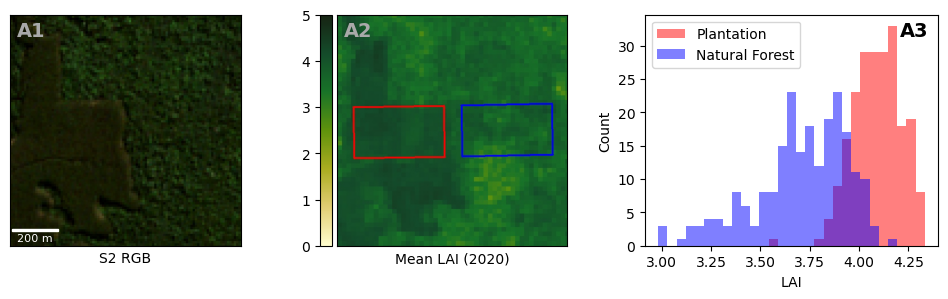

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# ======= A: Trait distribution analysis ========

fig, axs = plt.subplots(
    1, 3, figsize=(12, 3), gridspec_kw={"width_ratios": [0.8, 1, 1]}
)

LABELSIZE = 10
TITLESIZE = 14
LEGENDSIZE = 10
SCALEBAR_SIZE = 8
FIGURE_NUMBERING_SIZE = 14
NUMBERING_COLOR = "darkgrey"

# ======= A1: Sentinel-2 RGB Image ========
axs[0].imshow(url_to_image(thumbnail_url))
axs[0].set_xlabel("S2 RGB", fontsize=LABELSIZE)
axs[0].set_xticks([])
axs[0].set_yticks([])

# Add scale bar
scalebar = AnchoredSizeBar(
    axs[0].transData,
    102,  # Scale conversion
    "200 m",
    "lower left",
    color="white",
    frameon=False,
    size_vertical=3,
    fontproperties={"size": SCALEBAR_SIZE},
)
axs[0].add_artist(scalebar)

# ======= A2: Trait Map ========
axs[1].imshow(url_to_image(trait_map_url))
axs[1].set_xlabel("Mean LAI (2020)", fontsize=LABELSIZE)
axs[1].set_xticks([])
axs[1].set_yticks([])

# Colorbar positioning
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("left", size="5%", pad=0.05)

cb1 = fig.colorbar(
    cm.ScalarMappable(norm=colors["lai_norm"], cmap=colors["lai_cmap"]),
    cax=cax,
    orientation="vertical",
)
cax.yaxis.set_tick_params(labelsize=LEGENDSIZE)
cax.yaxis.set_ticks_position("left")
cax.yaxis.set_label_position("left")

# ======= A3: Histogram ========
axs[2].hist(pixels_geom_a, bins=bins, color="red", alpha=0.5, label="Plantation")
axs[2].hist(pixels_geom_b, bins=bins, color="blue", alpha=0.5, label="Natural Forest")
axs[2].set_xlabel("LAI", fontsize=LABELSIZE)
axs[2].set_ylabel("Count", fontsize=LABELSIZE)
# Increase legend size
axs[2].legend(prop={"size": LEGENDSIZE})

# Increase size of ticks
axs[2].tick_params(axis="both", which="major", labelsize=LEGENDSIZE)

# plt.tight_layout()

# Add subplot labels
axs[0].text(
    0.03,
    0.97,
    "A1",
    transform=axs[0].transAxes,
    fontsize=FIGURE_NUMBERING_SIZE,
    fontweight="bold",
    va="top",
    color="darkgrey",
)
axs[1].text(
    0.03,
    0.97,
    "A2",
    transform=axs[1].transAxes,
    fontsize=FIGURE_NUMBERING_SIZE,
    fontweight="bold",
    va="top",
    color="darkgrey",
)
axs[2].text(
    # 0.87,
    0.87,
    0.97,
    "A3",
    transform=axs[2].transAxes,
    fontsize=FIGURE_NUMBERING_SIZE,
    fontweight="bold",
    va="top",
    color="black",
)

plt.savefig("../plots/figure4A.png", dpi=300, bbox_inches="tight")
plt.show()

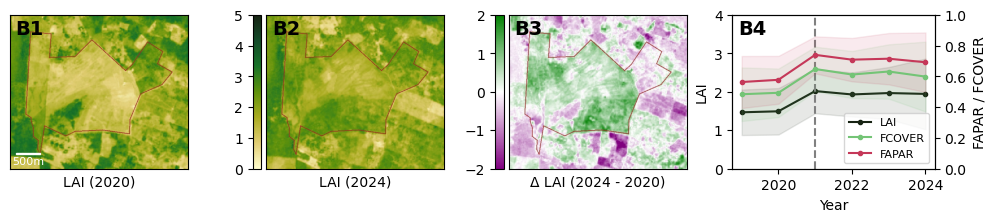

In [8]:
# ======= B: Reforestation Site Analysis ========
# get time-series per site (for all traits)
markersize = 3
markertype = "o"

# Colors and settings
colors_temp = {"lai": "#172313", "fapar": "#c53859", "fcover": "#74c476"}
labels = {"lai": "LAI", "fapar": "FAPAR", "fcover": "FCOVER"}
opacity_uncertainty = 0.1


fig, axs = plt.subplots(
    1,
    4,
    figsize=(12, 2),
    gridspec_kw={"width_ratios": [1.0, 1.0, 1.0, 1.0]},
    # 1, 4, figsize=(12, 2)
)

ax_B1, ax_B2, ax_B3, ax_B4 = axs

# ======= A1: Sentinel-2 RGB Image ========
# figure A
ax_B1.imshow(url_to_image(trait_map_url_pre))
ax_B1.set_xlabel("LAI (2020)", fontsize=LABELSIZE)
ax_B1.set_xticks([])
ax_B1.set_yticks([])
# ax_B1.axis("off")

# figure B
ax_B2.imshow(url_to_image(trait_map_url_post))
ax_B2.set_xlabel("LAI (2024)", fontsize=LABELSIZE)
ax_B2.set_xticks([])
ax_B2.set_yticks([])
# ax_B2.axis("off")

# figure C
ax_B3.imshow(url_to_image(trait_map_url_diff))
ax_B3.set_xlabel("Δ LAI (2024 - 2020)", fontsize=LABELSIZE)
ax_B3.set_xticks([])
ax_B3.set_yticks([])
# ax_B3.axis("off")


# add scale bar to image
scalebar = AnchoredSizeBar(
    ax_B1.transData,
    69,  # 512 pixels ~ 3700 meters // 512/3700*500 = 43
    "500m",  # Label for the scale bar
    "lower left",  # Location of the scale bar
    # pad=0.1,
    color="white",
    frameon=False,
    size_vertical=2,
    fontproperties={"size": SCALEBAR_SIZE},
)
ax_B1.add_artist(scalebar)

# add common colorbar to A/B
divider = make_axes_locatable(ax_B1)
cax = divider.append_axes("right", size="5%", pad=0.05)
# empty space for colorbar
cax.axis("off")
divider = make_axes_locatable(ax_B2)
cax = divider.append_axes("left", size="5%", pad=0.05)
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors["lai_norm"], cmap=colors["lai_cmap"]),
    cax=cax,
    orientation="vertical",
)
cax.yaxis.set_tick_params(labelsize=LEGENDSIZE)
cax.yaxis.set_ticks_position("left")
cax.yaxis.set_label_position("left")

# add colorbar to C
divider = make_axes_locatable(ax_B3)
cax = divider.append_axes("left", size="5%", pad=0.05)
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors["diff_lai_norm"], cmap=colors["diff_cmap"]),
    cax=cax,
    orientation="vertical",
)

cax.yaxis.set_tick_params(labelsize=LEGENDSIZE)
cax.yaxis.set_ticks_position("left")
cax.yaxis.set_label_position("left")
cb.ax.set_yticks(np.arange(-2, 3, 1))

axs = ax_B4
ts = get_time_series("lai", campeche)
axs.plot(
    ts.index,
    ts["lai_mean"],
    label="LAI",
    color=colors_temp["lai"],
    marker=markertype,
    markersize=markersize,
)
axs.fill_between(
    ts.index,
    ts["lai_mean"] - ts["lai_stdDev"],
    ts["lai_mean"] + ts["lai_stdDev"],
    color=colors_temp["lai"],
    alpha=opacity_uncertainty,
)

axs.grid(False)

# add dashed line at 2021: reforestation
axs.axvline(x=2021, color="grey", linestyle="--")

# add box at 2021 / 2022 : begin reforestation x = 2021, end reforestation x = 2022
# axs.axvspan(2021, 2022, color="grey", alpha=0.3)

axs_2 = axs.twinx()
axs_2.grid(False)
# then plot FCOVER time series / mean and uncertainty
ts = get_time_series("fcover", campeche)
axs_2.plot(
    ts.index,
    ts["fcover_mean"],
    label="FCOVER",
    color=colors_temp["fcover"],
    marker=markertype,
    markersize=markersize,
)
axs_2.fill_between(
    ts.index,
    ts["fcover_mean"] - ts["fcover_stdDev"],
    ts["fcover_mean"] + ts["fcover_stdDev"],
    color=colors_temp["fcover"],
    alpha=opacity_uncertainty,
)

# then plot FAPAR time series / mean and uncertainty
ts = get_time_series("fapar", campeche)
axs_2.plot(
    ts.index,
    ts["fapar_mean"],
    label="FAPAR",
    color=colors_temp["fapar"],
    marker=markertype,
    markersize=markersize,
)
axs_2.fill_between(
    ts.index,
    ts["fapar_mean"] - ts["fapar_stdDev"],
    ts["fapar_mean"] + ts["fapar_stdDev"],
    color=colors_temp["fapar"],
    alpha=opacity_uncertainty,
)

axs.set_ylim(0, 4)
axs.set_yticks(np.arange(0, 5, 1))
axs_2.set_ylim(0, 1)
axs_2.set_yticks(np.arange(0, 1.1, 0.2))
lines, labels = axs.get_legend_handles_labels()
lines2, labels2 = axs_2.get_legend_handles_labels()
axs.legend(lines + lines2, labels + labels2, loc="lower right", fontsize=LEGENDSIZE - 2)

axs.set_ylabel("LAI", fontsize=LABELSIZE)
axs_2.set_ylabel("FAPAR / FCOVER", fontsize=LABELSIZE)
axs.set_xlabel("Year", fontsize=LABELSIZE)

# add subplot labels B1, B2, B3, B4
ax_B1.text(
    0.03,
    0.97,
    "B1",
    transform=ax_B1.transAxes,
    fontsize=FIGURE_NUMBERING_SIZE,
    fontweight="bold",
    va="top",
    color="black",
)
ax_B2.text(
    0.03,
    0.97,
    "B2",
    transform=ax_B2.transAxes,
    fontsize=FIGURE_NUMBERING_SIZE,
    fontweight="bold",
    va="top",
    color="black",
)
ax_B3.text(
    0.03,
    0.97,
    "B3",
    transform=ax_B3.transAxes,
    fontsize=FIGURE_NUMBERING_SIZE,
    fontweight="bold",
    va="top",
    color="black",
)

ax_B4.text(
    0.03,
    0.97,
    "B4",
    transform=ax_B4.transAxes,
    fontsize=FIGURE_NUMBERING_SIZE,
    fontweight="bold",
    va="top",
    color="black",
)

plt.savefig("../plots/figure4B.png", dpi=300, bbox_inches="tight")
plt.show()

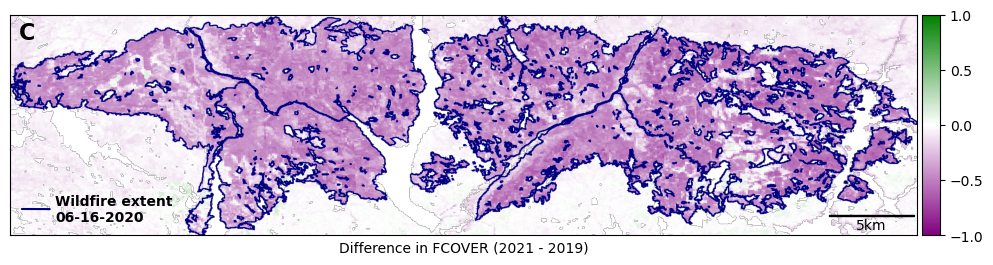

In [32]:
# ======= C: FCOVER Forest Fire Analysis ========

fig, axs = plt.subplots(
    1,
    1,
    figsize=(12, 3),
    # 1, 4, figsize=(12, 2)
)


# Display raster in subplot B
im = axs.imshow(
    url_to_image(url_fcover_diff_blended),
)

# ax_C.set_title("Difference in FCOVER (2021 - 2019)", fontsize=TITLESIZE)
axs.set_xlabel("Difference in FCOVER (2021 - 2019)", fontsize=LABELSIZE)
axs.set_xticks([])
axs.set_yticks([])
# ax_C.axis("off")

# # Create a divider for ax_A2 to position the colorbar separately
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="2%", pad=0.05)
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors["diff_fcover_norm"], cmap=colors["diff_cmap"]),
    cax=cax,
    orientation="vertical",
)
cb.ax.set_yticks(np.arange(-1, 1.1, 0.5))
cax.yaxis.set_tick_params(labelsize=LEGENDSIZE)

# Add text at bottom-left with an arrow pointing to wildfire extent
axs.annotate(
    "Wildfire extent\n06-16-2020",
    xy=(0.01, 0.12),  # Arrow tip location
    xytext=(0.05, 0.05),  # Text position (bottom-left)
    textcoords="axes fraction",
    xycoords="axes fraction",
    arrowprops=dict(color="#000080", arrowstyle="-", lw=1.5),
    fontsize=LABELSIZE,
    fontweight="bold",
    color="black",
    ha="left",
    va="bottom",
)

# add Label C
axs.text(
    0.01,
    0.97,
    "C",
    transform=axs.transAxes,
    fontsize=FIGURE_NUMBERING_SIZE + 2,
    fontweight="bold",
    va="top",
    color="black",
)

# add scalebar: 52861 meters length for 2048 pixels
scalebar = AnchoredSizeBar(
    axs.transData,
    193,  # 2048 / 52861 * 5000 = 193 ()
    "5km",
    "lower right",
    color="black",
    frameon=False,
    size_vertical=3,
    fontproperties={"size": SCALEBAR_SIZE + 2},
)
axs.add_artist(scalebar)

plt.savefig("../plots/figure4C.png", dpi=300, bbox_inches="tight")
plt.show()